In [25]:
# Initial code provided by Veena Suresh for the LSTM model
# This code for the BiLSTM model with additional outcome metrics

from datetime import datetime 
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Define the path to the dataset
dataset_path = 'C:/SIT378/Room2_npy'

# Define the target length for data trimming/padding
target_length = 750

# Define parameters for model
Model_type = "Bidirectional Long Short-Term Memory"
batchsize = 32
monitor_choice = 'val_loss'
dropout = 0.2
learningrate = 0.001

#Initialise lists
data_list = []
data_list1 = []
labels_list = []

classes_to_double = ["kneel", "liedown", "pickup"]

# Helper function to split sequences

def split_sequence(sequence, step):
    return [sequence[i:i + step] for i in range(0, len(sequence), step) if len(sequence[i:i + step]) == step]

# Traverse through each activity directory
for activity_folder in os.listdir(dataset_path):
    activity_path = os.path.join(dataset_path, activity_folder)
##    print(f"Processing activity: {activity_folder}")

    if os.path.isdir(activity_path):
        for participant_file in os.listdir(activity_path):
            participant_path = os.path.join(activity_path, participant_file)
            if os.path.isfile(participant_path) and participant_file.endswith('.npy'):
##                print(f"Loading data from file: {participant_file}")
                data = np.load(participant_path)
                data = np.real(data)

                # Split data into smaller sequences
                data_splits = split_sequence(data, target_length)

                for split_data in data_splits:
                    # Normalize data
                    min_val = np.min(split_data)
                    max_val = np.max(split_data)
                    data_normalized = (split_data - min_val) / (max_val - min_val) if max_val != min_val else np.zeros(split_data.shape)

                    label = activity_folder
#                    data_list1.append(data_normalized[:, 0:30])          
#                    labels_list.append(label)
#                    data_list1.append(data_normalized[:, 30:60])          
#                    labels_list.append(label)
                    data_list.append(data_normalized)          
                    labels_list.append(label)
                    if label in classes_to_double:
                        data_list.append(data_normalized.copy())  # Double the data
                        labels_list.append(label)  # Double the label

# Convert lists to arrays for machine learning processing
data = np.array(data_list)
labels = np.array(labels_list).reshape(-1, 1)

print("Final data shape:", data.shape)
print("Final labels shape:", labels.shape)

Final data shape: (1814, 750, 90)
Final labels shape: (1814, 1)


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

# Encode the labels before splitting the data
encoder = OneHotEncoder(sparse=False)
labels_encoded = encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train_encoded.shape)
print("Testing labels shape:", y_test_encoded.shape)


# Ensure Graphviz bin directory is in the PATH
os.environ["PATH"] += os.pathsep + 'C:\SIT378\windows_10_cmake_Release_Graphviz-12.1.0-win64\Graphviz-12.1.0-win64\bin'

# Define the BiLSTM model
model = Sequential()
model.add(Input(batch_size= batchsize,shape=(X_train.shape[1], X_train.shape[2])))
print(X_train.shape[0])
print(X_train.shape[1])
print(X_train.shape[2])
model.add(Bidirectional(LSTM(128, return_sequences=True), merge_mode= 'sum'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

# Compile the model with a different optimizer
optimizer = Adam(learning_rate=learningrate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Training data shape: (1451, 750, 90)
Testing data shape: (363, 750, 90)
Training labels shape: (1451, 8)
Testing labels shape: (363, 8)
1451
750
90


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (32, 750, 128)         │       224,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (32, 750, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (32, 750, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (32, 750, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (32, 750, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (32, 750, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (32, 64)               │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (32, 64)               │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (32, 8)                │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,208 (1.57 MB)

 Trainable params: 410,568 (1.57 MB)

 Non-trainable params: 640 (2.50 KB)

In [27]:
# Implement early stopping
monitor_choice = 'val_loss'
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

epochsvalue = 100

# start the timer for model training
start_time = datetime.now() 

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=epochsvalue, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

# Get the final training accuracy and loss
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]
print(f"Final training loss: {train_loss:.4f}")
print(f"Final training accuracy: {train_accuracy:.4f}")

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

#End timing and calculate total time for training
end_time = datetime.now() 
time_difference = (end_time - start_time).total_seconds()/60


Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.1285 - loss: 2.3921 - val_accuracy: 0.1074 - val_loss: 2.1591
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.1669 - loss: 2.2121 - val_accuracy: 0.1377 - val_loss: 2.1361
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.1646 - loss: 2.1542 - val_accuracy: 0.1901 - val_loss: 2.0396
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.2718 - loss: 1.9485 - val_accuracy: 0.2617 - val_loss: 1.9246
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3294 - loss: 1.7371 - val_accuracy: 0.3499 - val_loss: 1.7310
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3769 - loss: 1.6313 - val_accuracy: 0.2727 - val_loss: 2.1522
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4146 - loss: 1.5110 - val_accuracy: 0.2507 - val_loss: 2.1656
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4775 - loss: 1.3468 - val_accuracy: 0.1708 - v

In [28]:
# Save the model using the native Keras format
model.save('bilstm_model.keras')

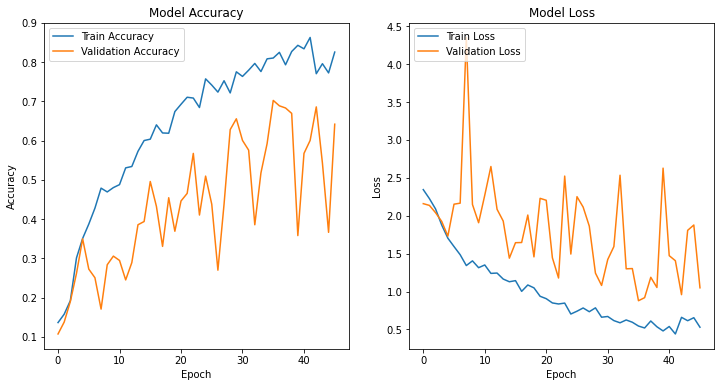

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/step

Model outcomes

Model type:  Bidirectional Long Short-Term Memory

Execution time of program is: 38.3 minutes

Test loss:       0.8785
Test accuracy:   0.7025
Batch Size:      32
Early Stopping:  val_loss
Dropout:         0.2
Learning Rate:   0.001

              precision    recall  f1-score   support

       Kneel       0.96      0.96      0.96        46
    Lie Down       0.81      0.78      0.80        60
     Pick Up       0.77      0.98      0.86        48
         Sit       0.94      0.60      0.73        50
  Sit Rotate       0.60      0.86      0.71        42
       Stand       0.65      0.33      0.44        51
Stand Rotate       0.41      0.67      0.50        42
        Walk       0.55      0.25      0.34        24

    accuracy                           0.70       363
   macro avg       0.71      0.68      0.67       363
weighted avg       0.73      0.70      0.69       363



<Figure size 864x576 with 0 Axes>

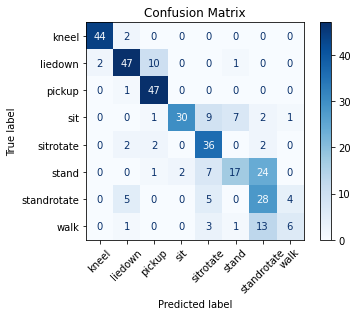

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Make predictions
y_pred_encoded = model.predict(X_test)
y_pred = np.argmax(y_pred_encoded, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Generate confusion matrix and model outcome metrics
cm = confusion_matrix(y_true, y_pred)
print()
print("Model outcomes")
print()
print("Model type: ", Model_type)
print()
print(f"Execution time of program is: {time_difference:.1f} minutes") 
print()
print(f"Test loss:       {test_loss:.4f}")
print(f"Test accuracy:   {test_accuracy:.4f}")
print("Batch Size:     ", batchsize)
print("Early Stopping: ", monitor_choice)
print("Dropout:        ", dropout)
print("Learning Rate:  ", learningrate)
print()
HAR_label = ['Kneel', 'Lie Down', 'Pick Up', 'Sit', 'Sit Rotate', 'Stand', 'Stand Rotate', 'Walk']

# Print classification report
print(classification_report(y_true, y_pred, zero_division=0, target_names=HAR_label))

#print(confusion_matrix[0, 0])
cmd = ConfusionMatrixDisplay(cm, display_labels=encoder.categories_[0])
plt.figure(figsize=(12, 8))
cmd.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()